# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import re
import nltk
import gzip
import shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support
from gensim.models.keyedvectors import KeyedVectors
import keras
from keras import backend
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input, LSTM, Lambda, Conv1D
from keras import layers
from keras.layers.merge import concatenate
from keras import preprocessing

Using TensorFlow backend.


# Download and extract the data

In [3]:
if('blogs.zip' not in os.listdir()):
    !curl 'http://u.cs.biu.ac.il/~koppel/blogs/blogs.zip' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -H 'User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'Referer: http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm' -H 'Accept-Encoding: gzip, deflate' -H 'Accept-Language: en-US,en;q=0.9' --compressed --output blogs.zip
    with zipfile.ZipFile('blogs.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

# Data cleaning and exploration

In [4]:
bloggers = os.listdir('blogs/')
print("There are {} bloggers".format(len(bloggers)))

There are 19320 bloggers


In [5]:
path = 'blogs/'

stop_words = nltk.corpus.stopwords.words("english")

with open(path+bloggers[0],'r',encoding="utf-8") as f:
    xml = f.read()

tags = set()
l = re.findall('<[^/].*?>',xml)
for el in l:
    tags.add(el)
print("The set of tags in the xml files are: {}".format(tags))

The set of tags in the xml files are: {'<post>', '<Blog>', '<date>'}


In [6]:
def data_2_frame(bloggers, sw = True):
    
    idx = []
    gender = []
    age = []
    industry = []
    astrologic = []
    dates = []
    posts = []
        
    for blogger in bloggers:

        try:
            
            with open(path+blogger,'r',encoding="utf-8") as f:
         
                xml = f.read()

        except UnicodeDecodeError:

            with open(path+blogger,'r',encoding="latin-1") as f:
                
                xml = f.read()
        
        if(sw):
            xml = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*','', xml)
            
        temp = re.findall('<post.*?>(.*?)</post>',xml,flags=re.DOTALL)
        
        posts += temp
        
        dates += re.findall('<date.*?>(.*?)</date>',xml,flags=re.DOTALL)

        nb_posts = len(temp)

        tmp = blogger.split(".")

        idx        += [tmp[0]]*nb_posts
        gender     += [tmp[1]]*nb_posts
        age        += [tmp[2]]*nb_posts
        industry   += [tmp[3]]*nb_posts
        astrologic += [tmp[4]]*nb_posts
    
    
    dico = {'id':idx,
        'gender':gender,
        'age':age,
        'industry':industry,
        'astrologic':astrologic,
        'post':posts,
        'date':dates}

    return pd.DataFrame.from_dict(dico)

In [7]:
data = data_2_frame(bloggers,True)

In [8]:
data.describe()

,id,gender,age,industry,astrologic,post,date
count,681288,681288,681288,681288,681288,681288,681288
unique,19320,2,26,40,12,612001,2616
top,449628,male,17,indUnk,Cancer,\n\n\t \n urlLink \n,"02,August,2004"
freq,4221,345197,80859,251015,65048,399,16545


In [9]:
data.head()

,id,gender,age,industry,astrologic,post,date
0,4200843,male,39,Technology,Sagittarius,"\n\n \n Why suns , obsession trying l...","21,August,2004"
1,4200843,male,39,Technology,Sagittarius,\n\n \n I'ordered Counter Strike:CZ ...,"18,August,2004"
2,4200843,male,39,Technology,Sagittarius,\n\n \n Remember jokes? Well I I nev...,"18,August,2004"
3,4200843,male,39,Technology,Sagittarius,\n\n \n If 'watch 'Waking Dead' make...,"16,August,2004"
4,4200843,male,39,Technology,Sagittarius,\n\n \n Sunday always feels like Sun...,"15,August,2004"


In [10]:
print("There are {0:.2f}% posts per male, and {1:.2f}% for female".format(data.\
gender[data.gender == 'male'].count()*100/data.gender.count(),data.gender[data.gender == 'female']\
.count()*100/data.gender.count()))

There are 50.67% posts per male, and 49.33% for female


In [11]:
words = []
posts = data.post.values
word_per_post = []

for post in posts:
    
    words+=post.split(" ")
    
    word_per_post.append(len(post.split(" ")) - np.sum(np.array(post.split(" ")) == ""))
    
unique_words = pd.unique(words)

print("There are {} words and {} unique words, that are non stop words in the corpus.".format(len(words),len(unique_words)))
print("Maximum words number per post: {}\nMinimum words number per post: {}\nAverage words number per post: {}\nMedian: {}\n80% of posts contains less or equal than {} words"\
      .format(np.max(word_per_post),np.min(word_per_post),np.mean(word_per_post),np.median(word_per_post),np.sort(word_per_post)[np.int(len(word_per_post)*0.8)]))

There are 101264977 words and 3912652 unique words, that are non stop words in the corpus.
Maximum words number per post: 78477
Minimum words number per post: 2
Average words number per post: 121.63884730099458
Median: 71.0
80% of posts contains less or equal than 180 words


# Baseline

In [12]:
maxlen = 180
max_words = 50000
embedding_dim = 300

tokenizer = Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(data.post.values)

sequences = np.array(tokenizer.texts_to_sequences(data.post.values))

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

X = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

y = data.gender.values

sss = StratifiedShuffleSplit(test_size = 0.25)

# utilise plabels au lieu de labels si tu veux tester sur les periodes
for train_index, test_index in sss.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

Found 1218159 unique tokens.


((510966, 180), (170322, 180), (510966, 2), (170322, 2))

In [27]:
def get_model(maxlen,max_words,embedding_dim,dropout = False):

    model = Sequential()
    model.add(Embedding(max_words,embedding_dim, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(128,activation="sigmoid"))
    if(dropout):
        model.add(Dropout(0.5))
        
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

def plot_acc(history):
    
    sns.set()

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20,10))

    epochs = np.arange(1, len(acc) + 1)

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [31]:
model = get_model(maxlen, max_words, embedding_dim,dropout=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 5, batch_size = 256, validation_split = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               6912128   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 21,912,257
Trainable params: 21,912,257
Non-trainable params: 0
_________________________________________________________________
None
Train on 408772 samples, validate on 102194 samples
Epoch 1/5
408772/408772 [==============================] - 55s 135us/step

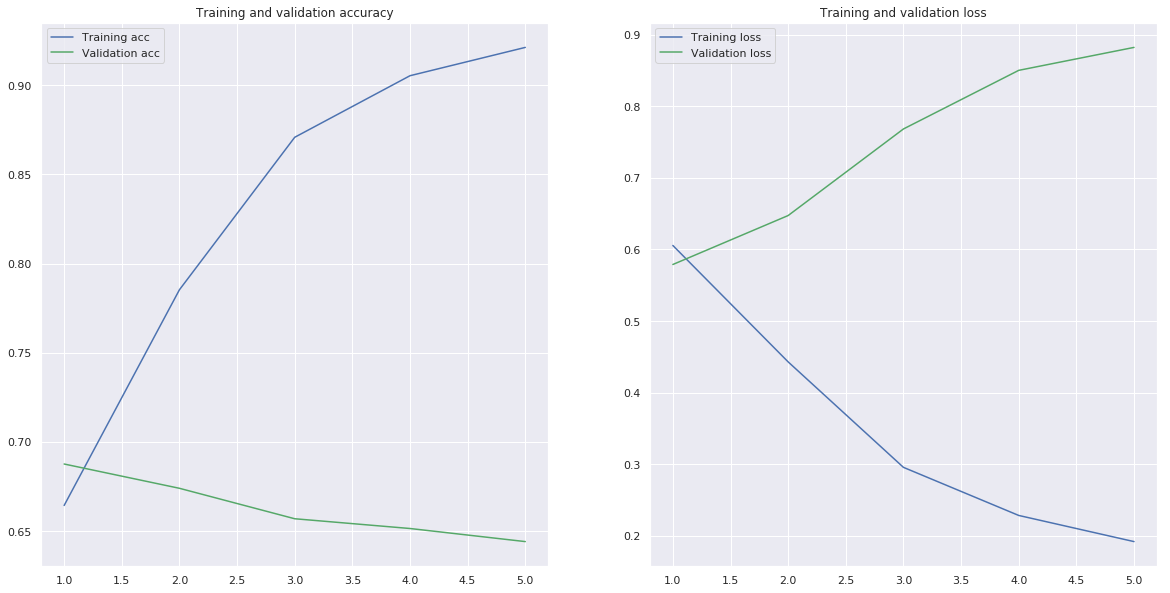

In [32]:
plot_acc(history)

In [33]:
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

170322/170322 [==============================] - 17s 97us/step
evaluate on test set  [0.8828357111241502, 0.6438275736574067]


In [34]:
results = model.evaluate(X_train, y_train['male'].values)
print("evaluate on train set ",results)

510966/510966 [==============================] - 55s 107us/step
evaluate on train set  [0.28423054210042686, 0.8837750456965903]


In [38]:
y_pred = model.predict(X_test)

pr, rc, fs,_ = precision_recall_fscore_support(y_test['male'].values,y_pred[:,0].round(),average='macro')

In [39]:
print("precision is {0}%, recall is {1}% and f1 score is {2}%".format(pr*100, rc*100, fs*100))

precision is 66.54577522839617%, recall is 65.20808907096935% and f1 score is 64.60991007878172%


In [54]:
model = get_model(maxlen, max_words, embedding_dim,dropout=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 2, batch_size = 256)

results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_6 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6912128   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 21,912,257
Trainable params: 21,912,257
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
510966/510966 [==============================] - 65s 127us/step - loss: 0.5994 - acc: 0.6696
Epoch 2/2
170322/17032

# Use of a pretrained embeddings

In [40]:
if('GoogleNews-vectors-negative300.bin.gz' not in os.listdir()):
    !curl 'https://doc-0s-bo-docs.googleusercontent.com/docs/securesc/irhn5id42n45amehdukhdmveaa64qdca/p3cdn432vvf0g873qt5fohervngkocsn/1547913600000/06848720943842814915/12338030662361016533/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&nonce=te8dhbikk60gq&user=12338030662361016533&hash=jmfhhq8ou6vcslfnjc1a36e5sjsap20h' -H 'authority: doc-0s-bo-docs.googleusercontent.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'x-client-data: CIa2yQEIprbJAQipncoBCKijygEIv6fKAQiQqMoBCOKoygEY+aXKAQ==' -H 'referer: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: AUTH_7ncsoht60h5nj3290k7ksjvs3qm9agnm_nonce=te8dhbikk60gq; NID=146=2m64YwK1FU_-wWYEr0N6qIT8KCPul94SVvGNE1YFUODGL-9ZZYgtf0PjHL_TrgeguaQjrWszdcM8aTlORHFViPx5R3pkEaM2uaQDIPyQkNY-ns5aQ0_77DSWxzvulfHWNxRIonT9b28IBORFdd1Cb8nPngy3F8nCQarRxGO2hNM' --compressed --output GoogleNews-vectors-negative300.bin.gz
    with gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb') as f_in:
        with open('GoogleNews-vectors-negative300.bin', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

In [41]:
embeddings_index = {}

with open("GoogleNews-vectors-negative300.txt") as f:
    for i,line in enumerate(f):
        if(i!=0):
            values = line.split()
            word = values[0]
            embeddings_index[word] = np.array(values[1:], dtype='float32')
        
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 2999999 word vectors.


In [42]:
embedding_dim = 300

c = 0
embedding_matrix = np.zeros((max_words, embedding_dim))

# eliminer les mots vides de l'embedding car il n'existe pas dans nos donnees
for word, i in word_index.items():
    if word not in stop_words and c < max_words:
    
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[c] = embedding_vector
            c+=1
            
c

50000

In [43]:
model = get_model(maxlen, max_words, embedding_dim, dropout=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_4 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               6912128   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 21,912,257
Trainable params: 21,912,257
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [45]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 5, batch_size = 256, validation_split = 0.2)

Train on 408772 samples, validate on 102194 samples
Epoch 1/5
408772/408772 [==============================] - 30s 74us/step - loss: 0.6936 - acc: 0.5316 - val_loss: 0.6852 - val_acc: 0.5460
Epoch 2/5
408772/408772 [==============================] - 29s 71us/step - loss: 0.6731 - acc: 0.5658 - val_loss: 0.6816 - val_acc: 0.5635
Epoch 3/5
408772/408772 [==============================] - 29s 71us/step - loss: 0.6465 - acc: 0.5960 - val_loss: 0.6949 - val_acc: 0.5614
Epoch 4/5
408772/408772 [==============================] - 30s 72us/step - loss: 0.6143 - acc: 0.6225 - val_loss: 0.7143 - val_acc: 0.5648
Epoch 5/5
408772/408772 [==============================] - 30s 72us/step - loss: 0.5848 - acc: 0.6446 - val_loss: 0.7434 - val_acc: 0.5603


In [46]:
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

170322/170322 [==============================] - 17s 99us/step
evaluate on test set  [0.7407198608529818, 0.5606556992071349]


In [47]:
results = model.evaluate(X_train, y_train['male'].values)
print("evaluate on train set ",results)

510966/510966 [==============================] - 53s 104us/step
evaluate on train set  [0.5769733653736233, 0.6607073660466722]


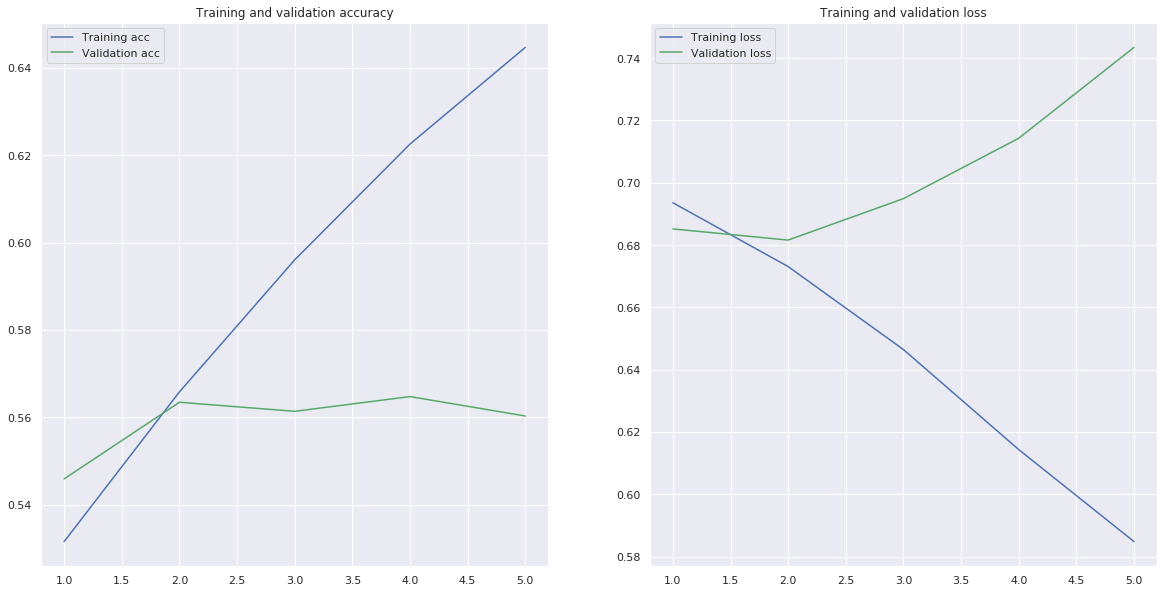

In [48]:
plot_acc(history)

In [ ]:
model = get_model(maxlen, max_words, embedding_dim, dropout=True)
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 3, batch_size = 256)
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

## with non-static embeddings

In [49]:
model = get_model(maxlen, max_words, embedding_dim, dropout = True)
model.layers[0].set_weights([embedding_matrix])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 180, 300)          15000000  
_________________________________________________________________
flatten_5 (Flatten)          (None, 54000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6912128   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 21,912,257
Trainable params: 21,912,257
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 5, batch_size = 256, validation_split = 0.2)

Train on 408772 samples, validate on 102194 samples
Epoch 1/5
408772/408772 [==============================] - 55s 134us/step - loss: 0.6347 - acc: 0.6370 - val_loss: 0.5803 - val_acc: 0.6897
Epoch 2/5
408772/408772 [==============================] - 53s 130us/step - loss: 0.5153 - acc: 0.7354 - val_loss: 0.5952 - val_acc: 0.6850
Epoch 3/5
408772/408772 [==============================] - 53s 130us/step - loss: 0.3850 - acc: 0.8155 - val_loss: 0.7038 - val_acc: 0.6689
Epoch 4/5
408772/408772 [==============================] - 53s 130us/step - loss: 0.2822 - acc: 0.8712 - val_loss: 0.8569 - val_acc: 0.6575
Epoch 5/5
408772/408772 [==============================] - 53s 129us/step - loss: 0.2217 - acc: 0.9019 - val_loss: 0.9385 - val_acc: 0.6535


In [51]:
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

170322/170322 [==============================] - 17s 98us/step
evaluate on test set  [0.9343347119465585, 0.6529338547008467]


In [52]:
results = model.evaluate(X_train, y_train['male'].values)
print("evaluate on train set ",results)

510966/510966 [==============================] - 52s 101us/step
evaluate on train set  [0.3179926628708498, 0.8765456018602397]


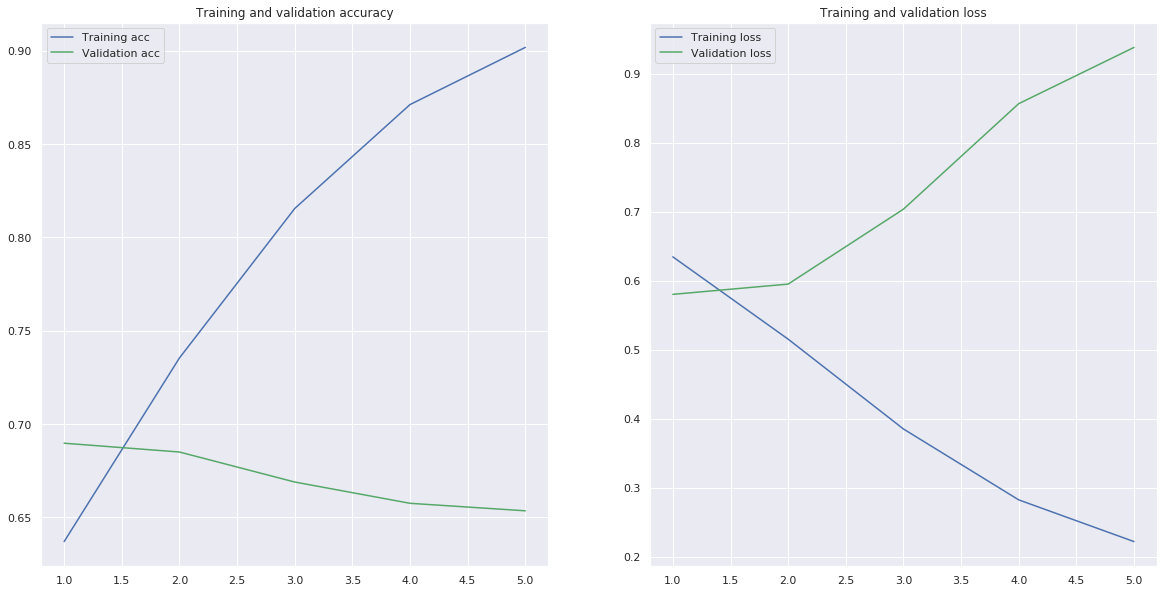

In [53]:
plot_acc(history)

In [ ]:
model = get_model(maxlen, max_words, embedding_dim, dropout=True)
model.layers[0].set_weights([embedding_matrix])
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["acc"])

history = model.fit(X_train, y_train['male'].values, epochs = 2, batch_size = 256)
results = model.evaluate(X_test, y_test['male'].values)
print("evaluate on test set ",results)

# Recurrent Convolutional Neural Network (RCNN)

In [55]:
hidden_dim1 = 200

hidden_dim2 = 100

document = Input(shape = (None, ), dtype = "int32")
left_context = Input(shape = (None, ), dtype = "int32")
right_context = Input(shape = (None, ), dtype = "int32")

In [56]:
embedder = Embedding(max_words , embedding_dim)
doc_embedding = embedder(document)
l_embedding = embedder(left_context)
r_embedding = embedder(right_context)

forward = LSTM(hidden_dim1, return_sequences = True)(l_embedding)
backward = LSTM(hidden_dim1, return_sequences = True, go_backwards = True)(r_embedding)
backward = Lambda(lambda x: backend.reverse(x, axes = 1))(backward)

together = concatenate([forward, doc_embedding, backward], axis = 2)

semantic = Conv1D(hidden_dim2, kernel_size = 1, activation = "tanh")(together)
pool_rnn = Lambda(lambda x: backend.max(x, axis = 1), output_shape = (hidden_dim2, ))(semantic)

output = Dense(1, input_dim = hidden_dim2, activation = "sigmoid")(pool_rnn)

In [57]:
left  = np.column_stack((np.array([0]*X_train.shape[0]),X_train[:,1:]))
right = np.column_stack((X_train[:,:-1],np.array([0]*X_train.shape[0])))
left.shape,right.shape

((510966, 180), (510966, 180))

In [58]:
model = Model(inputs = [document, left_context, right_context], outputs = output)

model.compile(optimizer = "adadelta", loss = "binary_crossentropy", metrics = ["accuracy"])

In [60]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 300)    15000000    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [59]:
history = model.fit([X_train, left, right], y_train['male'].values,batch_size = 256, epochs = 2)
loss = history.history["loss"][0]

Epoch 1/2
510966/510966 [==============================] - 1918s 4ms/step - loss: 0.6378 - acc: 0.6294
Epoch 2/2
510966/510966 [==============================] - 1930s 4ms/step - loss: 0.5840 - acc: 0.6859


In [56]:
left_test  = np.column_stack((np.array([0]*X_test.shape[0]),X_test[:,1:]))
right_test = np.column_stack((X_test[:,:-1],np.array([0]*X_test.shape[0])))
left_test.shape,right_test.shape

((170322, 180), (170322, 180))

In [58]:
results = model.evaluate([X_test,left_test,right_test], y_test['male'].values,batch_size=256)
print("evaluate on test set ",results)

170322/170322 [==============================] - 640s 4ms/step
evaluate on test set  [0.6210851892105415, 0.6513368795533445]
